**Daniel Yu & Jordan Wang**

Spring 2026

CS 443: Bio-inspired Machine Learning

# Project 1 | Hebbian Learning

The primary goal of this project is to explore how the biological Hebbian learning rule can be used for machine learning tasks as a viable alternative to artificial neural networks that rely exclusively on the backpropagation algorithm. The focus will be on using bio-inspired neural networks to achieve image classification accuracies that are:
- close to state-of-the-art for MNIST.
- competitive with backpropagation-based networks of comparable complexity on the CIFAR-10 image dataset.

Another goal of this project is to develop a TensorFlow-based, Keras-like, neural network library that will be leveraged and expanded upon in all subsequent projects throughout the semester. The library will allow neural networks to either:
- run on your laptop's central processing unit (CPU), as in CS343.
- be accelerated on graphics processing units (GPUs) in the cloud with minimal code changes (i.e. run substantially faster than on your laptop).

#### Week 1: TensorFlow, Datasets, and Custom Neural Network Library

The areas of focus this week are on:
- refreshing your memory of TensorFlow.
- gaining familiarity with running neural networks on GPUs and local vs. cloud computing workflows.
- building a pipeline to load and preprocess the MNIST and CIFAR-10 image datasets.
- build an simple single-layer artificial neural network using the TensorFlow low-level API and train it to classify images on MNIST and CIFAR-10.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.show()
plt.rcParams.update({'font.size': 18})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Task 1: Build an image dataset preprocessing pipeline

We will work with the MNIST or CIFAR-10 image datasets for a large portion of the semester so it will be helpful to develop a standardized and customizable pipeline for loading, preprocessing, and dividing up the datasets into train/val/test sets. Once built, the pipeline will enable loading either datasets with only several lines of code. Because we want our code to be able to run on GPUs, **you should write your pipeline in TensorFlow's low-level API rather than NumPy**.

**Note:** As you are refreshing your memory of TensorFlow, having the [TensorFlow documentation](https://www.tensorflow.org/api_docs/python/tf) and the CS343 TensorFlow tutorial (`TensorFlowTutorial.ipynb`) open is a good idea:



In [17]:
from image_datasets import get_dataset

### 1a. Loading and preprocessing CIFAR-10

In the `get_dataset` function of `image_datasets.py` use TensorFlow to load in and preprocess the CIFAR-10 dataset according to the specifications in the docstring. 

CIFAR-10 is similar to STL-10 in that it consists of small color images of natural scenes, but it is considerably larger ($N=60,000$ vs $N=5,000$). Here is some more information about CIFAR-10:
- Each RGB image is 32x32 resolution
- Each image is one of 10 classes: `airplane`, `automobile` `bird` `cat` `deer` `dog` `frog` `horse` `ship` and `truck`
- Unlike STL-10 whose images come from the famous ImageNet dataset, CIFAR-10 images are a subset of the (*also famous*) [80 Million Tiny Images](https://en.wikipedia.org/wiki/80_Million_Tiny_Images) dataset, which was released in 2009.


**Notes and reminders:**
1. For convenience, use TensorFlow Keras to download CIFAR-10 directly from the internet.
2. TensorFlow provides the CIFAR-10 images in 8-bit format, meaning the pixel values are integer values between 0 (dark) and 255 (light). Before you perform any preprocessing to the images (e.g. centering, standardizing), scale the features to floats between `0.0` and `1.0`.
3. The goal is to practice using TensorFlow so you should **not** be using NumPy (i.e. do **not** import it!).
4. See below for a refresher on the **'global'** standardization method.

#### Global RGB standardization

This approach to standardizing data refers:

$$
X_{\text{norm}} = \frac{ X - (R_{\text{mean}}, G_{\text{mean}}, B_{\text{mean}})}{(R_{\text{stddev}}, G_{\text{stddev}}, B_{\text{stddev}})}
$$

where $X$ is the original CIFAR-10 dataset (*either train or test set*) with shape (`(N, Iy, Ix, 3)`), $(R_{\text{mean}}, G_{\text{mean}}, B_{\text{mean}})$ has shape `(3,)` and is the global mean of all images within each RGB color channel, and $(R_{\text{stddev}}, G_{\text{stddev}}, B_{\text{stddev}})$ also has shape `(3,)` and is the global standard deviation of all images within each RGB color channel.

#### Test: CIFAR-10 loading

In [18]:
x_train, y_train, x_test, y_test = get_dataset('cifar10', norm_method='none')

print('The shape of your CIFAR-10 train and test sets are:')
print(f'{x_train.shape=} {y_train.shape=}')
print(f'{x_test.shape=} {y_test.shape=}')
print('and should be:')
print('''x_train.shape=TensorShape([50000, 3072]) y_train.shape=TensorShape([50000])
x_test.shape=TensorShape([10000, 3072]) y_test.shape=TensorShape([10000])''')
print()
print(f'Your training set min/max are {tf.reduce_min(x_train)}/{tf.reduce_max(x_train)} and should be 0.0/1.0')
print(f'The unique set of your train labels are {np.unique(y_train)} and should be [0 1 2 3 4 5 6 7 8 9]')
print(f'The unique set of your test labels are {np.unique(y_test)} and should be [0 1 2 3 4 5 6 7 8 9]')

Dataset: cifar10
x_train: (50000, 3072) <dtype: 'float32'>
y_train: (50000,) <dtype: 'uint8'>
x_test:  (10000, 3072) <dtype: 'float32'>
y_test:  (10000,) <dtype: 'uint8'>
The shape of your CIFAR-10 train and test sets are:
x_train.shape=TensorShape([50000, 3072]) y_train.shape=TensorShape([50000])
x_test.shape=TensorShape([10000, 3072]) y_test.shape=TensorShape([10000])
and should be:
x_train.shape=TensorShape([50000, 3072]) y_train.shape=TensorShape([50000])
x_test.shape=TensorShape([10000, 3072]) y_test.shape=TensorShape([10000])

Your training set min/max are 0.0/1.0 and should be 0.0/1.0
The unique set of your train labels are [0 1 2 3 4 5 6 7 8 9] and should be [0 1 2 3 4 5 6 7 8 9]
The unique set of your test labels are [0 1 2 3 4 5 6 7 8 9] and should be [0 1 2 3 4 5 6 7 8 9]


#### Test preserving original spatial dimensions

In [19]:
x_train, y_train, x_test, y_test = get_dataset('cifar10', norm_method='none', flatten=False)

print('The shape of your CIFAR-10 train and test sets are:')
print(f'{x_train.shape=} {y_train.shape=}')
print(f'{x_test.shape=} {y_test.shape=}')
print('and should be:')
print('''x_train.shape=TensorShape([50000, 32, 32, 3]) y_train.shape=TensorShape([50000])
x_test.shape=TensorShape([10000, 32, 32, 3]) y_test.shape=TensorShape([10000])''')

Dataset: cifar10
x_train: (50000, 32, 32, 3) <dtype: 'float32'>
y_train: (50000,) <dtype: 'uint8'>
x_test:  (10000, 32, 32, 3) <dtype: 'float32'>
y_test:  (10000,) <dtype: 'uint8'>
The shape of your CIFAR-10 train and test sets are:
x_train.shape=TensorShape([50000, 32, 32, 3]) y_train.shape=TensorShape([50000])
x_test.shape=TensorShape([10000, 32, 32, 3]) y_test.shape=TensorShape([10000])
and should be:
x_train.shape=TensorShape([50000, 32, 32, 3]) y_train.shape=TensorShape([50000])
x_test.shape=TensorShape([10000, 32, 32, 3]) y_test.shape=TensorShape([10000])


#### Test standardization

In [43]:
x_train, y_train, x_test, y_test = get_dataset('cifar10', norm_method='global')

print('The shape of your CIFAR-10 train and test sets are:')
print(f'{x_train.shape=} {y_train.shape=}')
print(f'{x_test.shape=} {y_test.shape=}')
print('and should be:')
print('''x_train.shape=TensorShape([50000, 3072]) y_train.shape=TensorShape([50000])
x_test.shape=TensorShape([10000, 3072]) y_test.shape=TensorShape([10000])''')
print()
print(f'The min/max of your training set is {tf.reduce_min(x_train):.4f}/{tf.reduce_max(x_train):.4f}')
print('and they should be                  -1.9892/2.1268')
print(f'The min/max of your test set is {tf.reduce_min(x_test):.4f}/{tf.reduce_max(x_test):.4f}')
print('and they should be              -1.9892/2.1268')

Dataset: cifar10
x_train: (50000, 3072) <dtype: 'float32'>
y_train: (50000,) <dtype: 'uint8'>
x_test:  (10000, 3072) <dtype: 'float32'>
y_test:  (10000,) <dtype: 'uint8'>
The shape of your CIFAR-10 train and test sets are:
x_train.shape=TensorShape([50000, 3072]) y_train.shape=TensorShape([50000])
x_test.shape=TensorShape([10000, 3072]) y_test.shape=TensorShape([10000])
and should be:
x_train.shape=TensorShape([50000, 3072]) y_train.shape=TensorShape([50000])
x_test.shape=TensorShape([10000, 3072]) y_test.shape=TensorShape([10000])

The min/max of your training set is -1.2222/2.5076
and they should be                  -1.9892/2.1268
The min/max of your test set is -1.2222/2.5076
and they should be              -1.9892/2.1268


#### Test centering

In [26]:
x_train, y_train, x_test, y_test = get_dataset('cifar10', norm_method='center', flatten=False)

print('The shape of your CIFAR-10 train and test sets are:')
print(f'{x_train.shape=} {y_train.shape=}')
print(f'{x_test.shape=} {y_test.shape=}')
print('and should be:')
print('''x_train.shape=TensorShape([50000, 32, 32, 3]) y_train.shape=TensorShape([50000])
x_test.shape=TensorShape([10000, 32, 32, 3]) y_test.shape=TensorShape([10000])''')
print()
print(f'The min/max of your training set is {tf.reduce_min(x_train):.4f}/{tf.reduce_max(x_train):.4f}')
print('and they should be                  -0.4914/0.5535')
print(f'The min/max of your test set is {tf.reduce_min(x_test):.4f}/{tf.reduce_max(x_test):.4f}')
print('and they should be              -0.4914/0.5535')

Dataset: cifar10
x_train: (50000, 32, 32, 3) <dtype: 'float32'>
y_train: (50000,) <dtype: 'uint8'>
x_test:  (10000, 32, 32, 3) <dtype: 'float32'>
y_test:  (10000,) <dtype: 'uint8'>
The shape of your CIFAR-10 train and test sets are:
x_train.shape=TensorShape([50000, 32, 32, 3]) y_train.shape=TensorShape([50000])
x_test.shape=TensorShape([10000, 32, 32, 3]) y_test.shape=TensorShape([10000])
and should be:
x_train.shape=TensorShape([50000, 32, 32, 3]) y_train.shape=TensorShape([50000])
x_test.shape=TensorShape([10000, 32, 32, 3]) y_test.shape=TensorShape([10000])

The min/max of your training set is -0.3277/0.6723
and they should be                  -0.4914/0.5535
The min/max of your test set is -0.3277/0.6723
and they should be              -0.4914/0.5535


### 1b. Creating train and validation splits

Given that CIFAR-10 is provided without a validation set, write code in the `train_val_split` fuction in `image_datasets.py`  to create one by paring down the training set. Afterwards, test out your code below.

In [27]:
from image_datasets import train_val_split

In [28]:
x_train_split, y_train_split, x_val_split, y_val_split = train_val_split(x_train, y_train, prop_val=0.25)

print('The shape of your CIFAR-10 train and val sets are:')
print(f'{x_train_split.shape=} {y_train_split.shape=}')
print(f'{x_val_split.shape=} {y_val_split.shape=}')
print('and should be:')
print('''x_train_split.shape=TensorShape([37500, 3072]) y_train_split.shape=TensorShape([37500])
x_val_split.shape=TensorShape([12500, 3072]) y_val_split.shape=TensorShape([12500])''')
print()
print(f'The first few val class labels are\n{y_val_split[:6]} and they should be\n[3 5 2 2 0 1]')

The shape of your CIFAR-10 train and val sets are:
x_train_split.shape=TensorShape([37500, 32, 32, 3]) y_train_split.shape=TensorShape([37500])
x_val_split.shape=TensorShape([12500, 32, 32, 3]) y_val_split.shape=TensorShape([12500])
and should be:
x_train_split.shape=TensorShape([37500, 3072]) y_train_split.shape=TensorShape([37500])
x_val_split.shape=TensorShape([12500, 3072]) y_val_split.shape=TensorShape([12500])

The first few val class labels are
[3 5 2 2 0 1] and they should be
[3 5 2 2 0 1]


### 1c. Visualize CIFAR-10 samples

Create a 7x7 grid showing first 49 CIFAR-10 training images in a grid/montage. You should use the class string of each sample as the title and there should not be any clutter created by grid lines/axes.

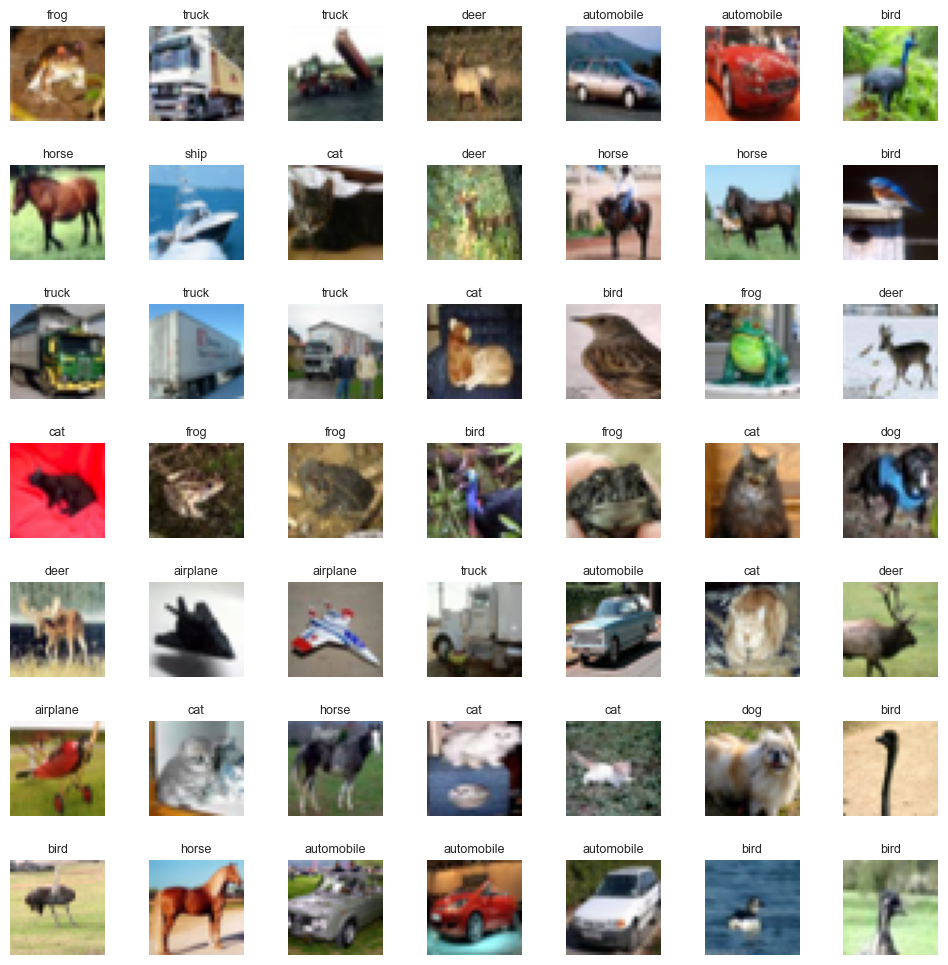

In [29]:
classnames = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(7, 7, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    img = x_train[i]
    label = y_train[i].numpy()

    # If images were standardized, rescale for display
    img_min = img.numpy().min()
    img_max = img.numpy().max()
    if img_min < 0 or img_max > 1:
        img = (img - img_min) / (img_max - img_min)

    ax.imshow(img)
    ax.set_title(classnames[label], fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

### 1d. Add support for MNIST

Modify `get_dataset` to load and preprocess the MNIST dataset.

**Notes:**
1. TensorFlow Keras should be used to download the dataset from the internet (*similar to CIFAR-10*).
2. Since MNIST consists of grayscale 28x28 images, the dataset comes without a color channel dimension (i.e. the shape is `(N, 28, 28)` rather than `(N, 28, 28, 1)`). It may be helpful to add a singleton dimension so that your preprocessing code works regardless of whether CIFAR-10 or MNIST is selected.

In [30]:
x_train, y_train, x_test, y_test = get_dataset('mnist')

print('--------------')
print('Your preprocessed shapes are:')
print(f'{x_train.shape=} {x_test.shape=}\n{y_train.shape=} {y_test.shape=}')
print('and should be:')
print('''x_train.shape=TensorShape([60000, 784]) x_test.shape=TensorShape([10000, 784])
y_train.shape=TensorShape([60000]) y_test.shape=TensorShape([10000])
''')
print('--------------')
print(f'Train min/max: {tf.reduce_min(x_train):.3f}/{tf.reduce_max(x_train):.3f} and should be -0.424/2.822')
print(f'Test min/max: {tf.reduce_min(x_test):.3f}/{tf.reduce_max(x_test):.3f} and should be -0.424/2.822')
print(f'Training samples {x_train.dtype=}, Test samples {x_test.dtype=}')
print(f'Training labels {y_train.dtype=}, Test labels {y_test.dtype=}')
print(f'Labels present in training set: {tf.sort(tf.unique(y_train)[0])}')
print(f'Labels present  in test set: {tf.sort(tf.unique(y_test)[0])}')
print('[You should have tf.float32 for x and tf.int32 for y]')
print('--------------')
print(f'First 5 training labels: {y_train[:5]} and should be [5 0 4 1 9]')
print(f'First 5 test labels: {y_test[:5]} and should be [7 2 1 0 4]')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Dataset: mnist
x_train: (60000, 784) <dtype: 'float32'>
y_train: (60000,) <dtype: 'uint8'>
x_test:  (10000, 784) <dtype: 'float32'>
y_test:  (10000,) <dtype: 'uint8'>
--------------
Your preprocessed shapes are:
x_train.shape=TensorShape([60000, 784]) x_test.shape=TensorShape([10000, 784])
y_train.shape=TensorShape([60000]) y_test.shape=TensorShape([10000])
and should be:
x_train.shape=TensorShape([60000, 784]) x_test.shape=TensorShape([10000, 784])
y_train.shape=TensorShape([60000]) y_test.shape=TensorShape([10000])

--------------
Train min/max: -0.424/2.822 and should be -0.424/2.822
Test min/max: -0.424/2.822 and should be -0.424/2.822
Training samples x_train.dtype=tf.float32, Test samples x_test.dtype=tf.float32
Training labels y_train.dtype=tf.uint8, Test labels y_test.dtype=tf.uint8
Labels present in training set: [0 1 2 3 4 5 6 7 8 9]
Labels present  in test set: [0 1 2 3 4 5 6 7 8 9]
[You should have tf.float32 for x and tf.i

### 1e. Visualize MNIST samples

Load in a fresh copy of MNIST, make a validation set using the default split, then use `draw_grid_image()` in `viz.py` in the cell below to create a `10x10` grid of the first 100 MNIST validation sample images.

This function places the image samples on a *single canvas* image (i.e. does not create subplots). Plotting one image instead an 2D array is more efficient (*you will be using this to visualize weights many times during training)*!

If you selected the first `N_val` samples for your validation set, the first two rows of your image should consist of the following digits:

```
[[5 3 5 0 0 1 8 4 3 4]
 [0 7 0 3 3 5 3 4 6 1]]
```

In [31]:
from viz import draw_grid_image

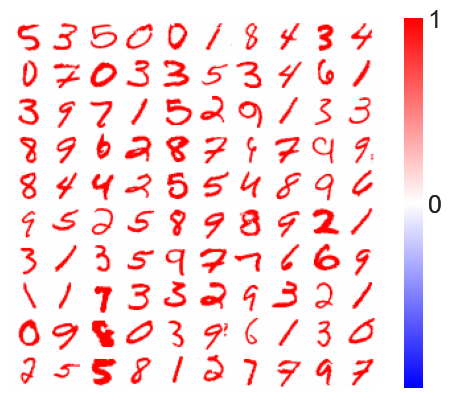

In [ ]:
x_train, y_train, x_test, y_test = get_dataset(
    'mnist',
    norm_method='none',
    flatten=False,
    verbose=False
)

x_train, y_train, x_val, y_val = train_val_split(x_train, y_train)

x_val_100 = x_val[:100]
y_val_100 = y_val[:100]

x_val_100 = tf.squeeze(x_val_100, axis=-1)

draw_grid_image(x_val_100, n_cols=10, n_rows=10)
